<a href="https://colab.research.google.com/github/anajvidovic/IAAC2024/blob/main/notebooks/06_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/STASYA00/IAAC2024_tutorials/blob/main/notebooks/06_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> - Stasja's notebook

### Data

⚠️ **NOTE:** Kaggle files have already been uploaded to the repo. You find them in folder `kaggle_data`´

If you for any reason need to download data from kaggle, instructions are in one of the [optional notebooks](./88_kaggle_data.ipynb) : <a href="https://colab.research.google.com/github/STASYA00/IAAC2024_tutorials/blob/main/notebooks/88_kaggle_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!git clone https://github.com/STASYA00/IAAC2024_tutorials
%cd IAAC2024_tutorials/notebooks

Cloning into 'IAAC2024_tutorials'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 164 (delta 40), reused 70 (delta 37), pack-reused 89
Receiving objects: 100% (164/164), 19.61 MiB | 9.15 MiB/s, done.
Resolving deltas: 100% (71/71), done.
/content/IAAC2024_tutorials/notebooks/IAAC2024_tutorials/notebooks


In [16]:
# importing the necessary packages
import calendar
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

In [17]:
metadata = pd.read_csv("../kaggle_data/tutorial_results/04_metadata.csv", index_col=0)
train = pd.read_csv("../kaggle_data/train.csv", index_col=0)
metadata.head()

,building_id,site_id,primaryspaceusage,sub_primaryspaceusage,sqm,timezone,electricity,hotwater,water,gas,industry,subindustry,heatingtype,yearbuilt,numberoffloors,occupants,rating
136,432,3,0,2,4703.0,1,0,0,0,0,0,2,11,0.0,5.0,378.9,1.0
137,416,3,0,2,499.3,1,0,1,0,0,0,2,7,0.0,4.0,104.8,0.0
138,436,3,0,2,9061.0,1,0,0,0,0,0,2,7,2005.0,10.0,523.2,2.0
139,441,3,0,3,7579.0,1,0,0,0,0,0,2,7,1913.0,5.0,517.9,0.0
140,442,3,0,3,5295.0,1,0,1,0,0,0,2,7,1953.0,6.0,378.9,1.0


In [18]:
full_df = train.merge(metadata, on='building_id', how='left')
full_df.head()

,building_id,day,meter,meter_reading,site_id,primaryspaceusage,sub_primaryspaceusage,sqm,timezone,electricity,hotwater,water,gas,industry,subindustry,heatingtype,yearbuilt,numberoffloors,occupants,rating
0,2,2016-02-02,595,102.6,0,1,4,811.0,1,0,0,0,1,1,9,5,1976.0,1.0,20.6,3.0
1,2,2016-02-02,207,0.3,0,1,4,811.0,1,0,0,0,1,1,9,5,1976.0,1.0,20.6,3.0
2,2,2016-02-03,595,88.8,0,1,4,811.0,1,0,0,0,1,1,9,5,1976.0,1.0,20.6,3.0
3,2,2016-02-03,207,0.1,0,1,4,811.0,1,0,0,0,1,1,9,5,1976.0,1.0,20.6,3.0
4,2,2016-02-04,595,76.3,0,1,4,811.0,1,0,0,0,1,1,9,5,1976.0,1.0,20.6,3.0


In [71]:
full_df["primaryspaceusage"].value_counts()

0     145873
6      47775
1      36946
4       9555
8       8918
3       4459
5       4459
9       3822
7       1911
10      1274
2        637
11       637
Name: primaryspaceusage, dtype: int64

In [72]:
full_df["year"] = full_df["day"].apply(lambda s: s.year)
full_df["month"] = full_df["day"].apply(lambda s: s.month)
full_df["day_number"] = full_df["day"].apply(lambda s: s.day)
full_df["weekday"] = full_df["day"].apply(lambda s: s.weekday() in [5, 6])

In [73]:
target = "meter_reading"
meter_dict = {595:0, 207:1, 649:2, 413:3}
full_df["meter"].replace(meter_dict, inplace=True)
X = full_df.drop(columns=[target]).loc[full_df[target].isna()==False]
Y = full_df[target].loc[full_df[target].isna()==False]


## 🏡 Buildings' Efficiency - Time Series and (Finally) Predictions

##### 🧩 Task I - Finding patterns in groups

Look at combinations of columns and aggregation levels that you think could be significant for resolving this problem. Plot your visualizations and discuss the patterns.

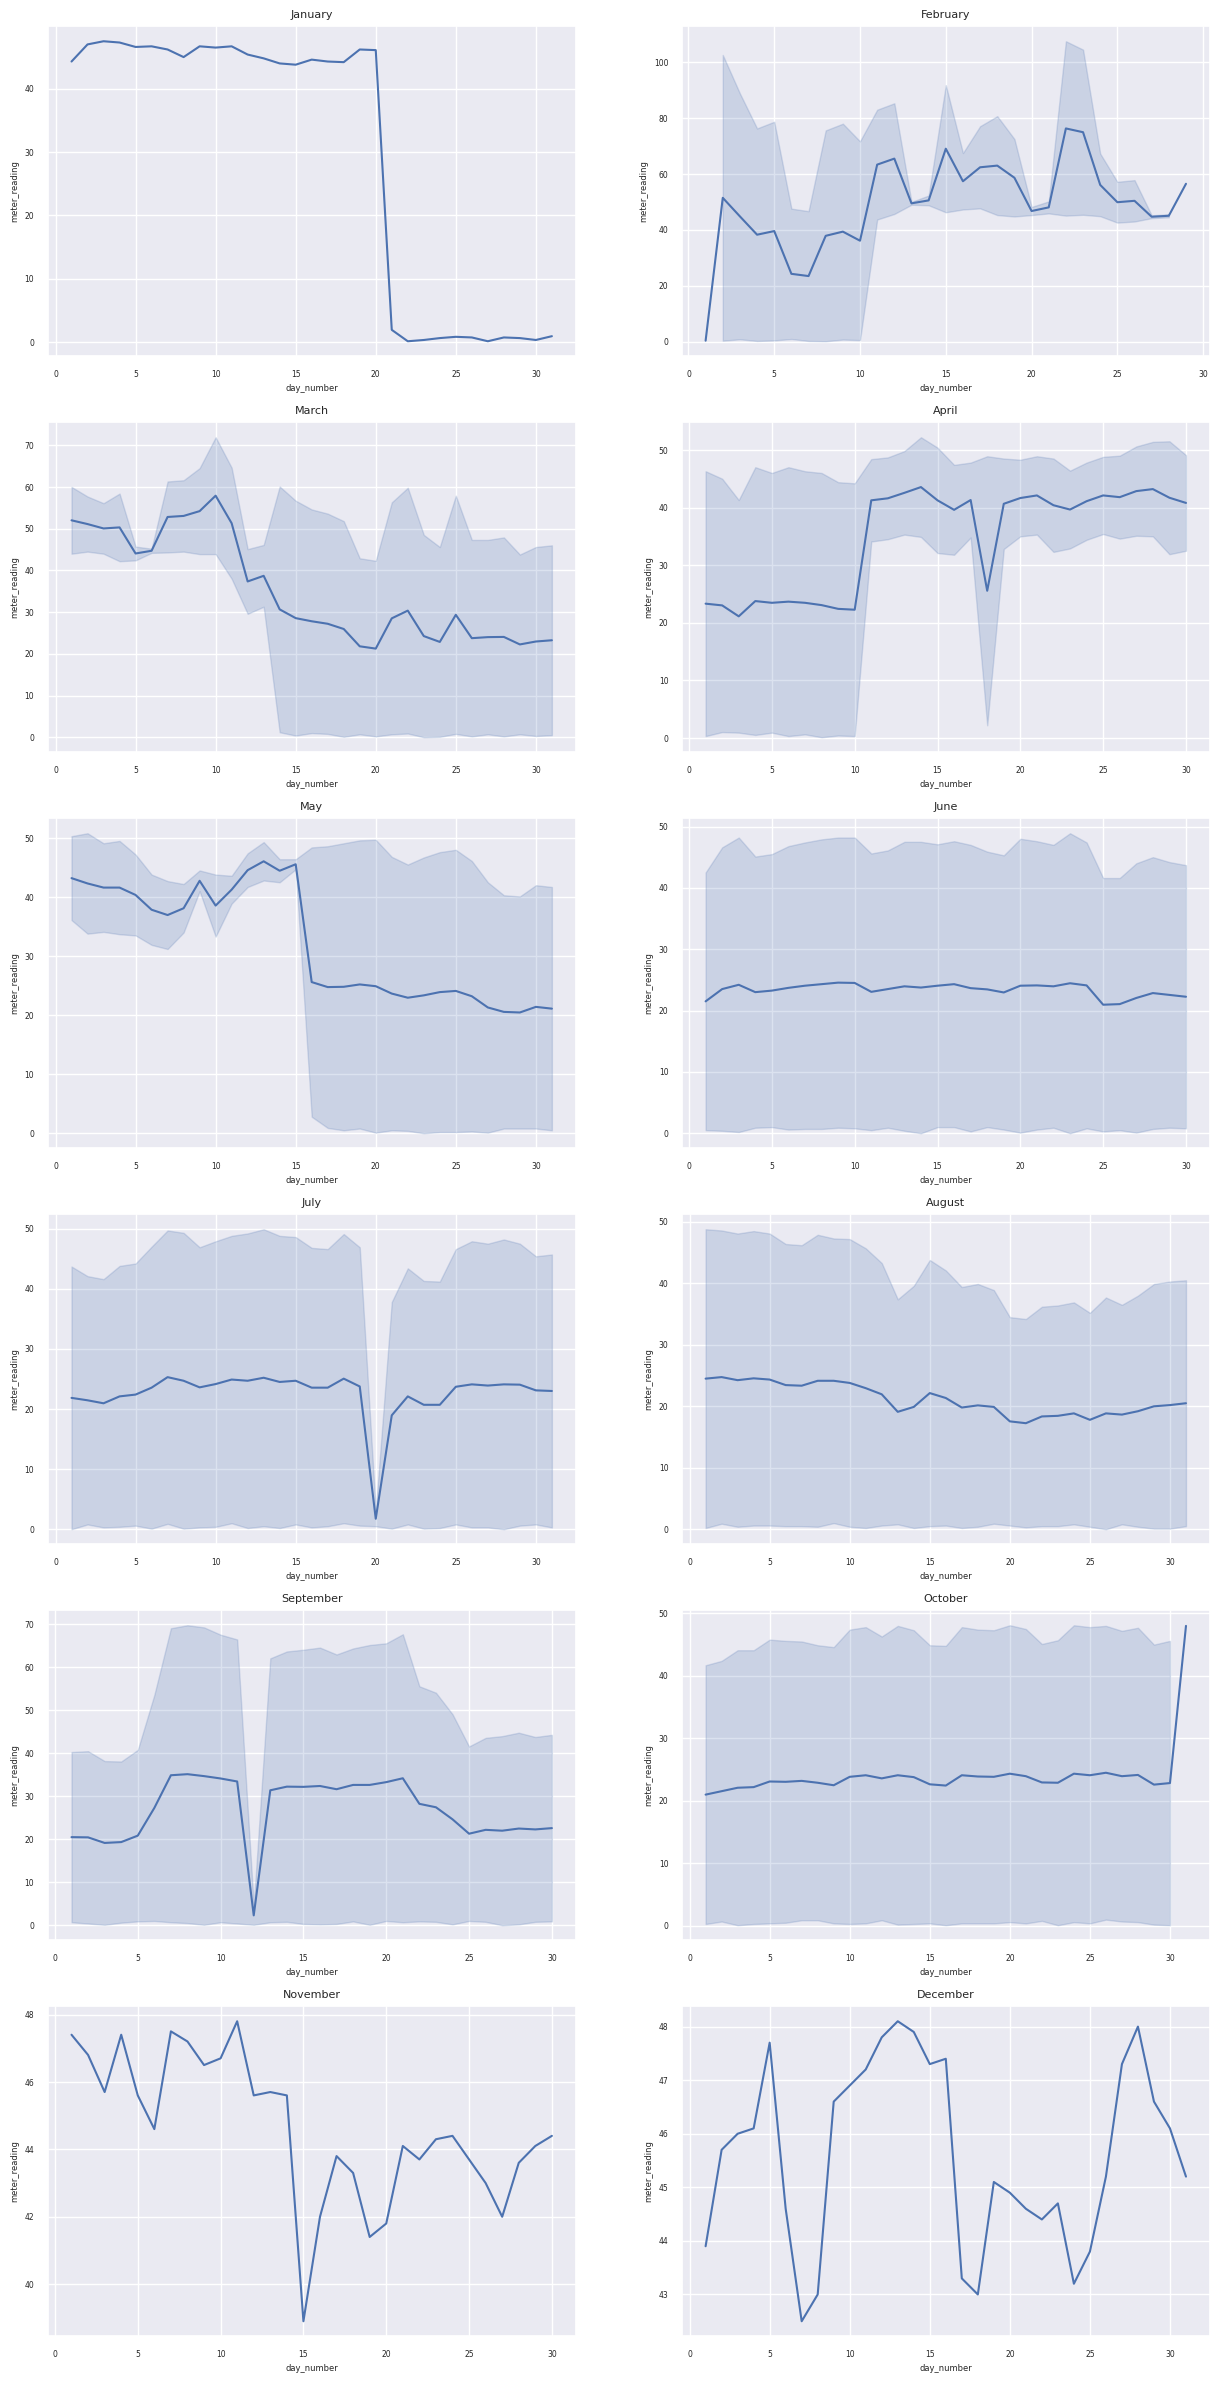

In [83]:
sns.set(font_scale=0.5, rc={'figure.figsize':(25,8)})
fig, axes = plt.subplots(6, 2, figsize=(15, 30))
for i in range(12):
    sns.lineplot(data=full_df.loc[full_df["building_id"]==2].loc[full_df["meter"]==0].loc[full_df["month"]==i+1],
                 x="day_number", y=target, ax=axes[int(i/2)][i%2])
    axes[int(i/2)][i%2].set_title(calendar.month_name[i+1], fontsize=8)

### 🫧 Autoregression

Let's first write a function to split time data in one line:

In [84]:
def split_time_data(df:pd.DataFrame):
    _df = df.sort_values(by=["day"])
    split_percent = 0.8

    X = _df.drop(columns=[target]).loc[_df[target].isna()==False]
    Y = _df[target].loc[_df[target].isna()==False]

    X_train = X[:int(X.shape[0] * split_percent)].drop(columns=["day"])
    X_valid = X[int(X.shape[0] * split_percent):].drop(columns=["day"])
    Y_train = Y[:int(X.shape[0] * split_percent)]
    Y_valid = Y[int(X.shape[0] * split_percent):]

    return X_train, X_valid, Y_train, Y_valid


In [85]:
X_train, X_valid, Y_train, Y_valid = split_time_data(full_df)

In [86]:
model = RandomForestRegressor(n_estimators=10, random_state=154).fit(X_train, Y_train)
score = model.score(X_valid, Y_valid)
print(score)

0.6261102490465669


##### 🪸 Shifts

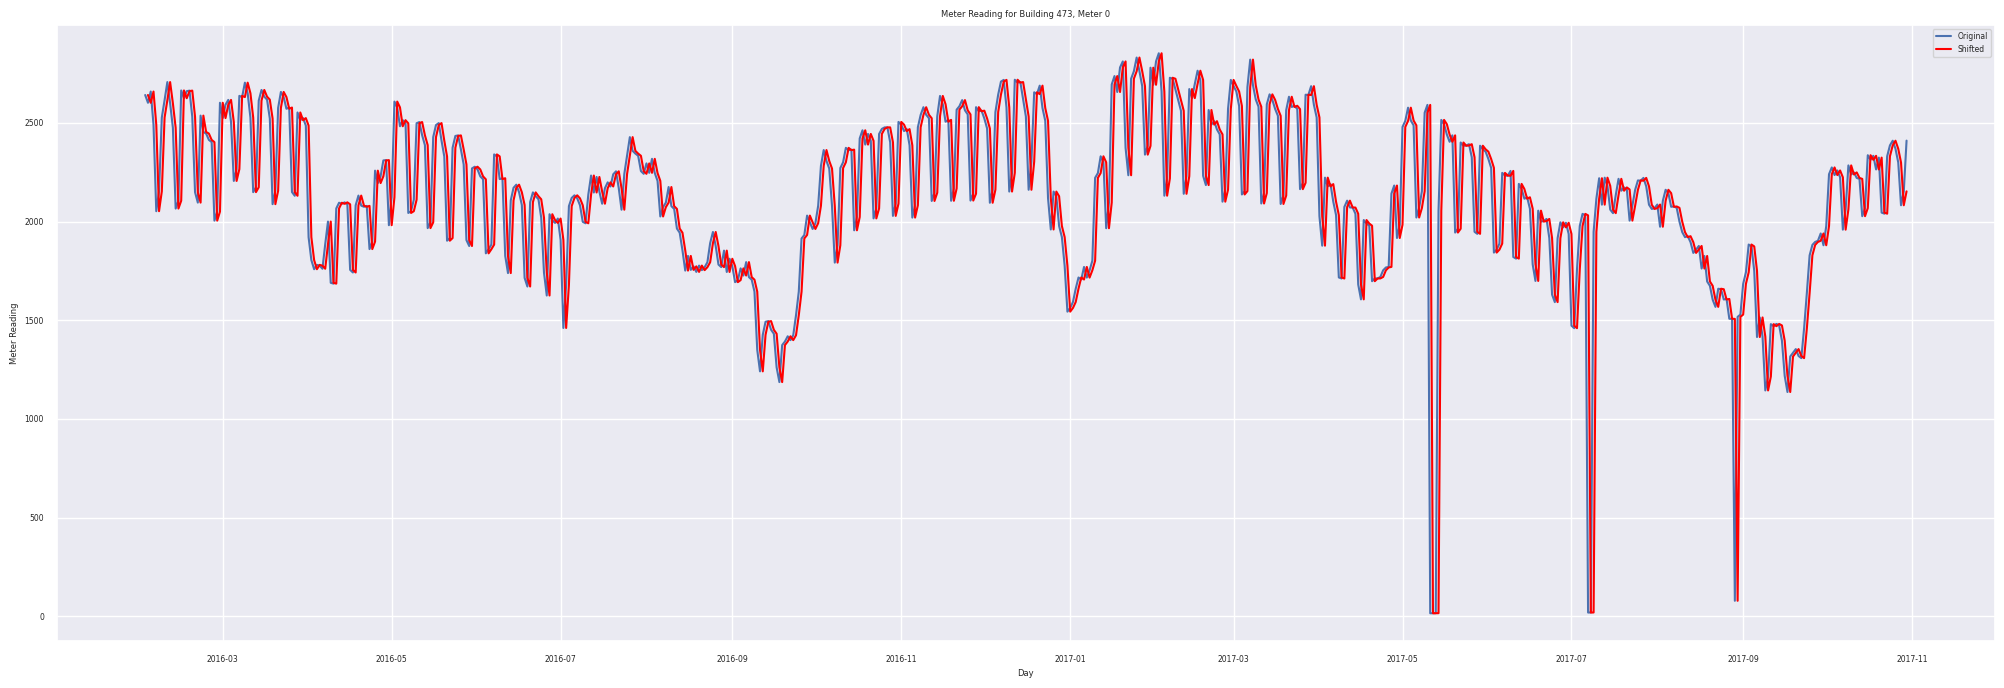

In [106]:
#1 Day
BID = 473
meter_type = 0

full_df['shifted_meter_reading'] = full_df.loc[(full_df["building_id"]==BID) & (full_df["meter"]==meter_type), 'meter_reading'].shift(1)

ax = sns.lineplot(data=full_df.loc[(full_df["building_id"]==BID) & (full_df["meter"]==meter_type)], x="day", y="meter_reading", label="Original")
sns.lineplot(data=full_df.loc[(full_df["building_id"]==BID) & (full_df["meter"]==meter_type)], x="day", y="shifted_meter_reading", ax=ax, label="Shifted", color='red')

plt.title(f'Meter Reading for Building {BID}, Meter {meter_type}')
plt.xlabel('Day')
plt.ylabel('Meter Reading')
plt.legend()
plt.show()


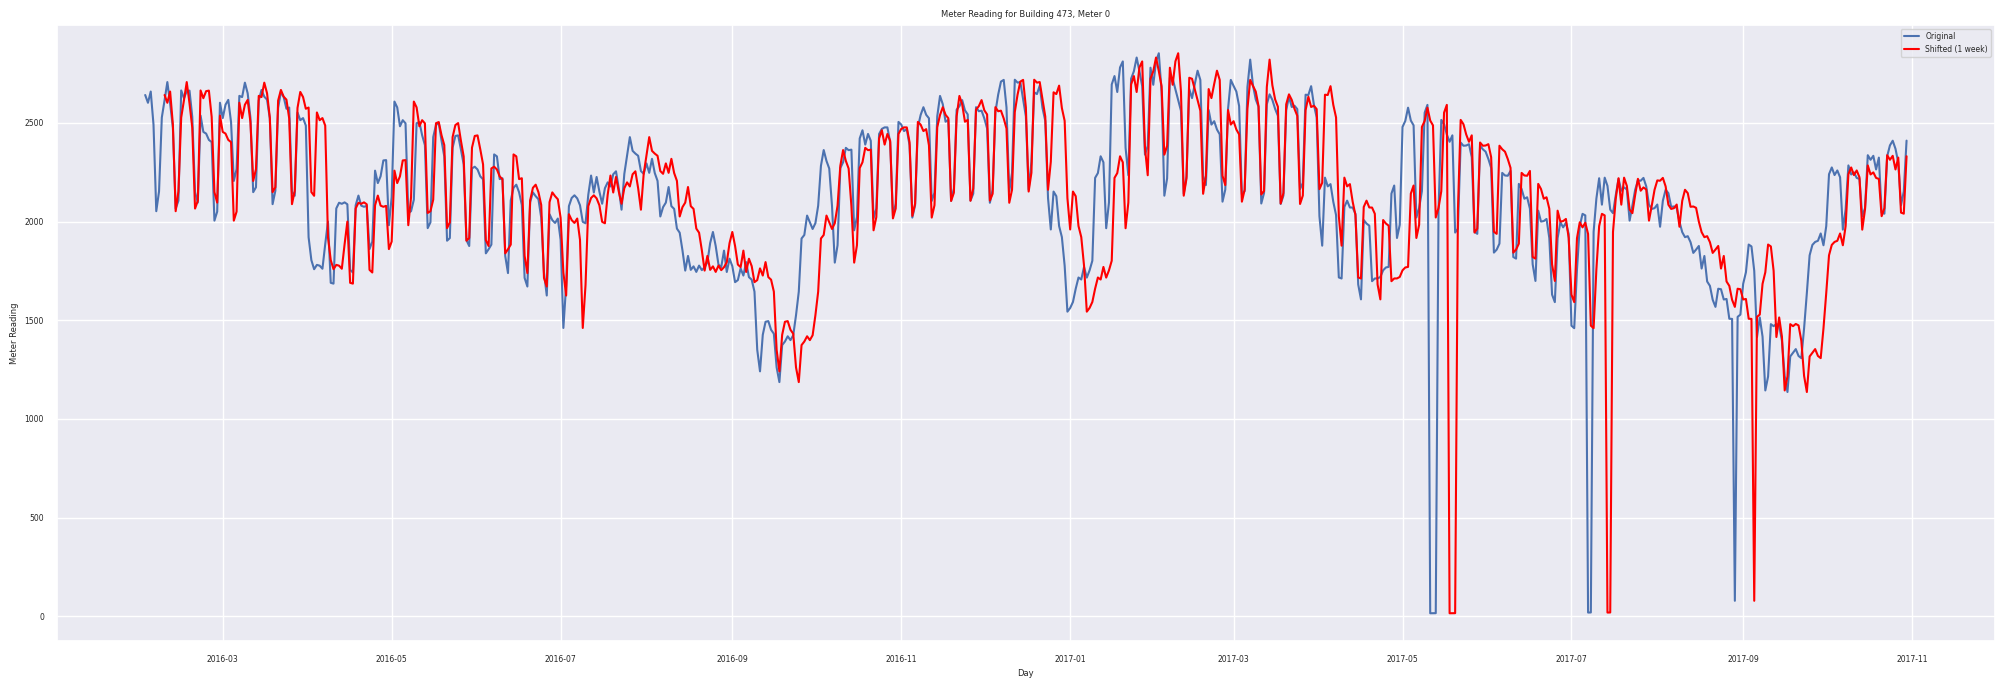

In [107]:
#1 week
BID = 473
meter_type = 0

full_df['shifted_meter_reading'] = full_df.loc[(full_df["building_id"]==BID) & (full_df["meter"]==meter_type), 'meter_reading'].shift(7)

ax = sns.lineplot(data=full_df.loc[(full_df["building_id"]==BID) & (full_df["meter"]==meter_type)], x="day", y="meter_reading", label="Original")
sns.lineplot(data=full_df.loc[(full_df["building_id"]==BID) & (full_df["meter"]==meter_type)], x="day", y="shifted_meter_reading", ax=ax, label="Shifted (1 week)", color='red')

plt.title(f'Meter Reading for Building {BID}, Meter {meter_type}')
plt.xlabel('Day')
plt.ylabel('Meter Reading')
plt.legend()
plt.show()


Compare:

In [108]:
print(Y_train.shift(1).head() )

0              NaN
133134     102.600
85359     4689.995
85358      747.297
147784     352.300
Name: meter_reading, dtype: float64


In [109]:
print(Y_train.shift(2).head())

0              NaN
133134         NaN
85359      102.600
85358     4689.995
147784     747.297
Name: meter_reading, dtype: float64


##### Adding one shift to dataframe

In [110]:
X_train_lags = pd.concat([X_train, pd.DataFrame(Y_train.shift(1))], ignore_index=True, axis=1).fillna(0)
X_valid_lags = pd.concat([X_valid, pd.DataFrame(Y_valid.shift(1))], ignore_index=True, axis=1).fillna(0)

In [111]:
model = RandomForestRegressor(n_estimators=10, random_state=154).fit(X_train_lags, Y_train)
score = model.score(X_valid_lags, Y_valid)
print(score)

0.6991782464023363


🚫🚫🚫 **BUT**

Our data is not consequent. Right now we have many building ids, meters and so on. If we simply shift data by 1 (or more) we would get input from other buildings or meteres, probably from the same day. For one building and one meter it would work though, but we have too few samples. \
Let's write a function that would return the predictions from given building, given meter for the previous day:

In [112]:
full_df_sorted = full_df.sort_values(by=["building_id", "meter", "day"])

full_df_sorted.head(15)

,building_id,day,meter,meter_reading,site_id,primaryspaceusage,sub_primaryspaceusage,sqm,timezone,electricity,...,heatingtype,yearbuilt,numberoffloors,occupants,rating,year,month,day_number,weekday,shifted_meter_reading
0,2,2016-02-02,0,102.6,0,1,4,811.0,1,0,...,5,1976.0,1.0,20.6,3.0,2016,2,2,False,NaN
2,2,2016-02-03,0,88.8,0,1,4,811.0,1,0,...,5,1976.0,1.0,20.6,3.0,2016,2,3,False,NaN
4,2,2016-02-04,0,76.3,0,1,4,811.0,1,0,...,5,1976.0,1.0,20.6,3.0,2016,2,4,False,NaN
6,2,2016-02-05,0,78.7,0,1,4,811.0,1,0,...,5,1976.0,1.0,20.6,3.0,2016,2,5,False,NaN
8,2,2016-02-06,0,47.6,0,1,4,811.0,1,0,...,5,1976.0,1.0,20.6,3.0,2016,2,6,True,NaN
10,2,2016-02-07,0,46.7,0,1,4,811.0,1,0,...,5,1976.0,1.0,20.6,3.0,2016,2,7,True,NaN
12,2,2016-02-08,0,75.6,0,1,4,811.0,1,0,...,5,1976.0,1.0,20.6,3.0,2016,2,8,False,NaN
14,2,2016-02-09,0,78.0,0,1,4,811.0,1,0,...,5,1976.0,1.0,20.6,3.0,2016,2,9,False,NaN
16,2,2016-02-10,0,71.7,0,1,4,811.0,1,0,...,5,1976.0,1.0,20.6,3.0,2016,2,10,False,NaN
18,2,2016-02-11,0,83.0,0,1,4,811.0,1,0,...,5,1976.0,1.0,20.6,3.0,2016,2,11,False,NaN


In [113]:
_lags = pd.DataFrame(full_df_sorted[target].shift(1))
_lags.rename(lambda s: "lag_1", axis='columns', inplace=True)
full_df_sorted_lags = pd.concat([full_df_sorted, _lags], axis=1)

"""
Since we have changed the order of the rows, all the buildings except for the first one will get the input from another building on the first day.
Let's fix it and assign a missing value to the first day lag:
"""
full_df_sorted_lags.loc[full_df_sorted_lags["day"]==full_df_sorted_lags["day"][0], "lag_1"] = 0
full_df_sorted_lags.head()

,building_id,day,meter,meter_reading,site_id,primaryspaceusage,sub_primaryspaceusage,sqm,timezone,electricity,...,yearbuilt,numberoffloors,occupants,rating,year,month,day_number,weekday,shifted_meter_reading,lag_1
0,2,2016-02-02,0,102.6,0,1,4,811.0,1,0,...,1976.0,1.0,20.6,3.0,2016,2,2,False,NaN,0.0
2,2,2016-02-03,0,88.8,0,1,4,811.0,1,0,...,1976.0,1.0,20.6,3.0,2016,2,3,False,NaN,102.6
4,2,2016-02-04,0,76.3,0,1,4,811.0,1,0,...,1976.0,1.0,20.6,3.0,2016,2,4,False,NaN,88.8
6,2,2016-02-05,0,78.7,0,1,4,811.0,1,0,...,1976.0,1.0,20.6,3.0,2016,2,5,False,NaN,76.3
8,2,2016-02-06,0,47.6,0,1,4,811.0,1,0,...,1976.0,1.0,20.6,3.0,2016,2,6,True,NaN,78.7


In [114]:
# reversing the sorting order back to the original one:
full_df_sorted_lags = full_df_sorted_lags.sort_index(axis=0)
full_df_sorted_lags.head()

,building_id,day,meter,meter_reading,site_id,primaryspaceusage,sub_primaryspaceusage,sqm,timezone,electricity,...,yearbuilt,numberoffloors,occupants,rating,year,month,day_number,weekday,shifted_meter_reading,lag_1
0,2,2016-02-02,0,102.6,0,1,4,811.0,1,0,...,1976.0,1.0,20.6,3.0,2016,2,2,False,NaN,0.0
1,2,2016-02-02,1,0.3,0,1,4,811.0,1,0,...,1976.0,1.0,20.6,3.0,2016,2,2,False,NaN,0.0
2,2,2016-02-03,0,88.8,0,1,4,811.0,1,0,...,1976.0,1.0,20.6,3.0,2016,2,3,False,NaN,102.6
3,2,2016-02-03,1,0.1,0,1,4,811.0,1,0,...,1976.0,1.0,20.6,3.0,2016,2,3,False,NaN,0.3
4,2,2016-02-04,0,76.3,0,1,4,811.0,1,0,...,1976.0,1.0,20.6,3.0,2016,2,4,False,NaN,88.8


In [115]:
# Repeating the procedure:

X_train, X_valid, Y_train, Y_valid = split_time_data(full_df_sorted_lags)

In [118]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Instantiate and fit the model
model = HistGradientBoostingRegressor()
model.fit(X_train, Y_train)

# Evaluate the model
score = model.score(X_valid, Y_valid)
print(score)

0.7005372876008539


##### Adding several shifts to dataframe

Let's write a function to simplify shifts generation:

In [119]:
def make_shifts(df, shifts=3):
    _df_sorted = df.sort_values(by=["building_id", "meter", "day"])
    _lags = pd.DataFrame({"lag_{}".format(i): _df_sorted[target].shift(i+1) for i in range(shifts)})
    _df_sorted_lags = pd.concat([_df_sorted, _lags], axis=1)

    """
    Since we have changed the order of the rows, all the buildings except for the first one will get the input from another building on the first day.
    Let's fix it and assign a missing value to the first day lag:
    """
    for i in range(shifts):
        for j in range(0, i+1):
            _df_sorted_lags.loc[_df_sorted_lags["day"]==_df_sorted_lags["day"]- timedelta(days=int(j)), "lag_{}".format(i)] = 0

    _df_sorted_lags = _df_sorted_lags.sort_index(axis=0)
    return _df_sorted_lags

In [120]:
df7 = make_shifts(full_df, 7)
X_train, X_valid, Y_train, Y_valid = split_time_data(df7)

In [121]:
df7.head()

,building_id,day,meter,meter_reading,site_id,primaryspaceusage,sub_primaryspaceusage,sqm,timezone,electricity,...,day_number,weekday,shifted_meter_reading,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6
0,2,2016-02-02,0,102.6,0,1,4,811.0,1,0,...,2,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2016-02-02,1,0.3,0,1,4,811.0,1,0,...,2,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2016-02-03,0,88.8,0,1,4,811.0,1,0,...,3,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,2016-02-03,1,0.1,0,1,4,811.0,1,0,...,3,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,2016-02-04,0,76.3,0,1,4,811.0,1,0,...,4,False,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Instantiate and fit the model
model = HistGradientBoostingRegressor()
model.fit(X_train, Y_train)

# Evaluate the model
score = model.score(X_valid, Y_valid)
print(score)

0.6273411024267743
